In [1]:
!pip install fbprophet

# New Section

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv("/content/drive/MyDrive/Time-Series-with-Facebook-Prophet/google-data.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [6]:
df.Date = df.Date.apply(pd.to_datetime)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [8]:
sample=df[["Date", "Close"]]

In [9]:
sample.columns=["ds", "y"]

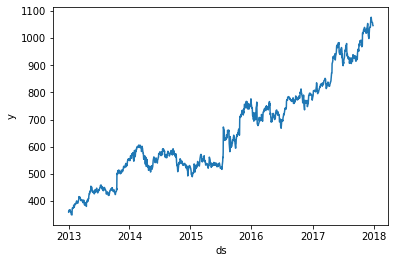

In [10]:
sns.lineplot(x=sample.ds,y=sample.y)
plt.show()

In [11]:
train=sample.iloc[:-100,]
test=sample.iloc[-100:,]

In [12]:
model=Prophet()
model.fit(train)
forecast=model.make_future_dataframe(periods=100, freq="D")
predictions=model.predict(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,386.997704,346.162098,399.817906,386.997704,386.997704,-14.746664,-14.746664,-14.746664,6.879679,6.879679,6.879679,-21.626343,-21.626343,-21.626343,0.0,0.0,0.0,372.251039
1,2013-01-03,387.169039,343.607840,396.226836,387.169039,387.169039,-16.293346,-16.293346,-16.293346,5.926867,5.926867,5.926867,-22.220213,-22.220213,-22.220213,0.0,0.0,0.0,370.875693
2,2013-01-04,387.340375,344.574642,396.213585,387.340375,387.340375,-16.544963,-16.544963,-16.544963,6.222136,6.222136,6.222136,-22.767100,-22.767100,-22.767100,0.0,0.0,0.0,370.795412
3,2013-01-07,387.854382,342.971639,397.536364,387.854382,387.854382,-18.135633,-18.135633,-18.135633,5.974312,5.974312,5.974312,-24.109944,-24.109944,-24.109944,0.0,0.0,0.0,369.718749
4,2013-01-08,388.025718,344.124235,395.054651,388.025718,388.025718,-18.246958,-18.246958,-18.246958,6.210030,6.210030,6.210030,-24.456988,-24.456988,-24.456988,0.0,0.0,0.0,369.778760


In [14]:
preds=predictions[["ds","yhat"]]
preds.head()

,ds,yhat
0,2013-01-02,372.251039
1,2013-01-03,370.875693
2,2013-01-04,370.795412
3,2013-01-07,369.718749
4,2013-01-08,369.778760


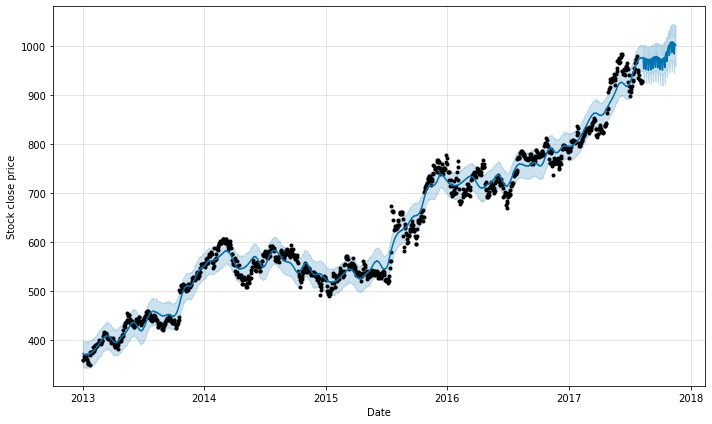

In [15]:
model.plot(predictions, xlabel="Date", ylabel="Stock close price");

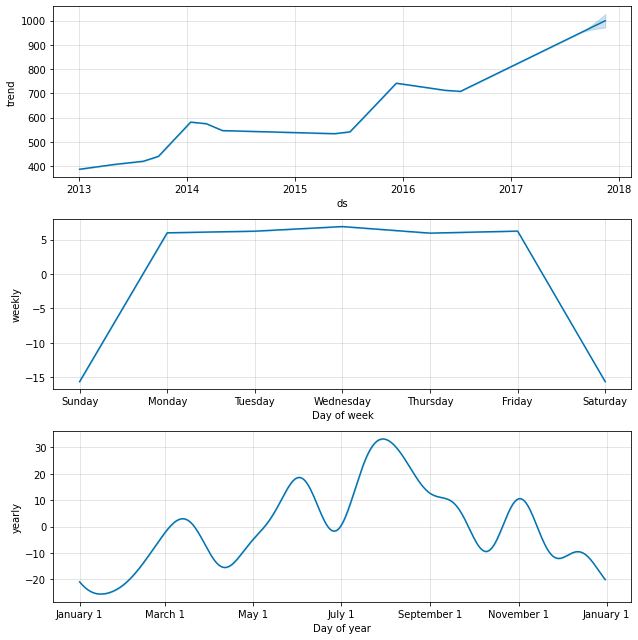

In [16]:
model.plot_components(predictions);

In [17]:
y_pred=preds.iloc[-100:,1]
y_test=test.y


In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print ("Root Mean Square Error:" , rmse)

Root Mean Square Error: 44.31477243427674


In [20]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 48.3 MB/s 
     |████████████████████████████████| 80 kB 7.6 MB/s 
     |████████████████████████████████| 75 kB 3.0 MB/s 
     |████████████████████████████████| 111 kB 55.8 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 144 kB 46.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=b65ac9d3250bfed01d871b0bf49e4d37e292077d3a7625afbbeb8f0f96435ae5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [31]:
import optuna
from fbprophet.diagnostics import cross_validation, performance_metrics

In [32]:
m = Prophet()
m.fit(sample) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
number_initial_days = 366

In [34]:
sample_cv = cross_validation(m,
                         initial=f'{number_initial_days} days', 
                         period='180 days', 
                         horizon = '100 days',
                         parallel='processes')

sample_p = performance_metrics(sample_cv)

INFO:fbprophet:Making 8 forecasts with cutoffs between 2014-04-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c54e2bad0>


In [35]:
param_types = {'changepoint_prior_scale': 'float', 
               'seasonality_prior_scale': 'float',
              'seasonality_mode': 'int'}

In [36]:
bounds = {'changepoint_prior_scale': [0.001, 0.5],
          'seasonality_prior_scale': [0.01, 10],
          'seasonality_mode': [0, 1]}

In [37]:
def objective(trial):
    '''Train a prophet model and return the rmse'''
    # sampling
    params = {}
    for param in ['changepoint_prior_scale', 'seasonality_prior_scale']:
        params[param] = trial.suggest_uniform(param, bounds[param][0], bounds[param][1])
        
    stationality = ['additive', 'multiplicative']
    params['seasonality_mode'] = stationality[trial.suggest_int('seasonality_mode', 
                                                                  bounds['seasonality_mode'][0], 
                                                                  bounds['seasonality_mode'][1])]

    # modeling
    m = Prophet(weekly_seasonality=True,
                daily_seasonality=False,
                **params)
    
    m.fit(sample) 
    number_initial_days = 500
    df_cv = cross_validation(m, 
                             initial=f'{number_initial_days} days', 
                             period='180 days', 
                         horizon = '100 days',
                         parallel='processes')
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p['mape'].mean())
    
    return df_p['rmse'].values[0]

In [39]:
study = optuna.create_study()
study.optimize(objective, n_trials = 10)
study.best_params

[I 2021-10-22 15:25:38,765] A new study created in memory with name: no-name-d1fcb2f4-1b90-480e-b4bc-f87bd466ff75
INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48c504d0>
[I 2021-10-22 15:26:30,447] Trial 0 finished with value: 119.04266903241097 and parameters: {'changepoint_prior_scale': 0.21557994779463915, 'seasonality_prior_scale': 9.754682468409426, 'seasonality_mode': 1}. Best is trial 0 with value: 119.04266903241097.


0.12508940843896119


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48c50190>
[I 2021-10-22 15:26:57,322] Trial 1 finished with value: 89.90678275464663 and parameters: {'changepoint_prior_scale': 0.15114662634925063, 'seasonality_prior_scale': 3.7050511094577305, 'seasonality_mode': 0}. Best is trial 1 with value: 89.90678275464663.


0.10058262892463618


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48cc5cd0>
[I 2021-10-22 15:27:24,877] Trial 2 finished with value: 91.84976298842919 and parameters: {'changepoint_prior_scale': 0.21916209431578734, 'seasonality_prior_scale': 3.1051856677252707, 'seasonality_mode': 0}. Best is trial 1 with value: 89.90678275464663.


0.10091886495107837


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48c53ad0>
[I 2021-10-22 15:28:13,209] Trial 3 finished with value: 107.26320686152292 and parameters: {'changepoint_prior_scale': 0.09573748482300132, 'seasonality_prior_scale': 4.494140630942391, 'seasonality_mode': 1}. Best is trial 1 with value: 89.90678275464663.


0.11690284455996096


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48c53c50>
[I 2021-10-22 15:28:50,966] Trial 4 finished with value: 129.13347285935393 and parameters: {'changepoint_prior_scale': 0.4363222725562304, 'seasonality_prior_scale': 1.410463452757274, 'seasonality_mode': 1}. Best is trial 1 with value: 89.90678275464663.


0.1412716747441236


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48c53ad0>
[I 2021-10-22 15:29:35,994] Trial 5 finished with value: 129.94966526704863 and parameters: {'changepoint_prior_scale': 0.2615466407395512, 'seasonality_prior_scale': 9.745513201466089, 'seasonality_mode': 1}. Best is trial 1 with value: 89.90678275464663.


0.1426417634685352


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48bf9450>
[I 2021-10-22 15:30:16,191] Trial 6 finished with value: 128.25961883580368 and parameters: {'changepoint_prior_scale': 0.3871583184408172, 'seasonality_prior_scale': 1.5986101986433727, 'seasonality_mode': 1}. Best is trial 1 with value: 89.90678275464663.


0.14072174678025148


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48c12e10>
[I 2021-10-22 15:30:44,686] Trial 7 finished with value: 86.89351047932361 and parameters: {'changepoint_prior_scale': 0.44839597177063517, 'seasonality_prior_scale': 5.721601667720318, 'seasonality_mode': 0}. Best is trial 7 with value: 86.89351047932361.


0.09811779390674537


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48c12c90>
[I 2021-10-22 15:31:26,268] Trial 8 finished with value: 134.98037929822019 and parameters: {'changepoint_prior_scale': 0.38628757070287545, 'seasonality_prior_scale': 9.495911682988023, 'seasonality_mode': 1}. Best is trial 7 with value: 86.89351047932361.


0.15135460571616038


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0c48bec610>
[I 2021-10-22 15:31:44,434] Trial 9 finished with value: 83.60932018136724 and parameters: {'changepoint_prior_scale': 0.04989966344362823, 'seasonality_prior_scale': 5.9425958426084495, 'seasonality_mode': 0}. Best is trial 9 with value: 83.60932018136724.


0.0928400212874163


{'changepoint_prior_scale': 0.04989966344362823,
 'seasonality_mode': 0,
 'seasonality_prior_scale': 5.9425958426084495}

In [40]:
params = study.best_params

In [41]:
params["seasonality_mode"] = "additive"

In [42]:
model = Prophet(weekly_seasonality=True,
                daily_seasonality=False,
                **params)

model.fit(train)
forecast = model.make_future_dataframe(periods = 100, freq= "D")
predictions = model.predict(forecast)
preds = predictions[["ds", "yhat"]]
y_pred = preds.iloc[-100:, 1]
y_test = test.y

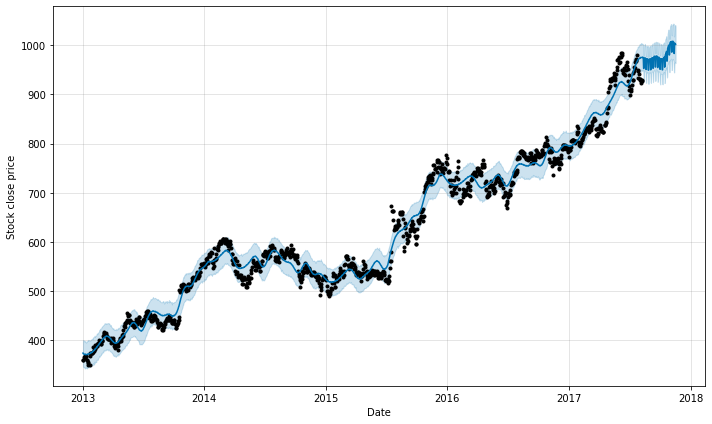

In [44]:
model.plot(predictions, xlabel = "Date", ylabel= "Stock close price");

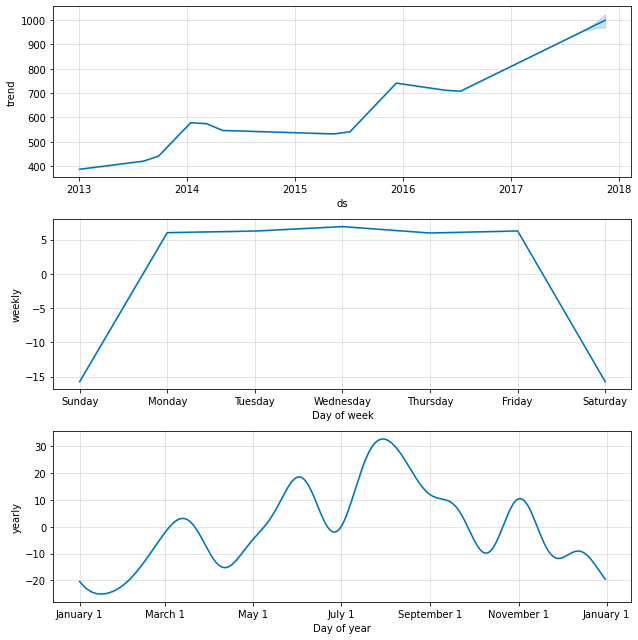

In [45]:
model.plot_components(predictions);